# Merging Spatial Data Sets

Like regular pandas DataFrames, GeoDataFrames can be merged with one another based on common merging variables. *Unlike* regular DataFrames, however, GeoDataFrames can also be merged based on spatial relationships using *spatial joins* with `sjoin` and `sjoin_nearest`.

## Regular Merges

Regular merges (on attributes) work with dataframes in the familiar way, *except* that the syntax is just a little different. In particular, to merge a GeoDataFrame `gdf` with a DataFrame `df`, you would type `gdf.merge(df, on="key")` instead of the familiar `pd.merge(gdf, df)`. This helps ensure that geopandas knows that you want to keep `gdf` as a geodataframe.





## Spatial Join

The idea of a spatial join is that instead of joining rows across datasets based on common values of a variable, rows are joined based on spatial proximity. To illustrate, let's being with two datasets: the dataset of countries we've been playing with already, and a dataset of cities:

<Axes: >

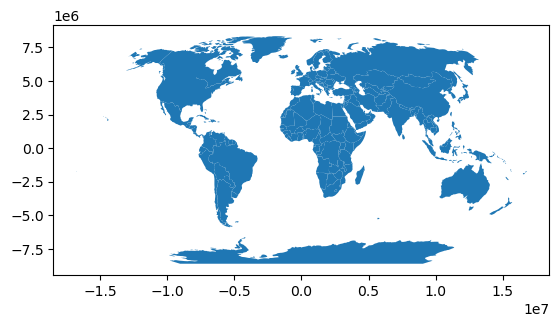

In [1]:
import geopandas as gpd

world = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/raw/refs"
    "/heads/main/notebooks/gis/example_data/world_countries/world_countries.geojson"
)
world.plot()

In [2]:
world.sample(3)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,pop_density,geometry
88,Admin-0 country,1,4,Oman,OMN,0,2,Sovereign country,1,Oman,...,None,None,None,None,None,None,None,None,12.131417,"MULTIPOLYGON (((5098648.549 2428704.726, 50971..."
24,Admin-0 country,1,5,East Timor,TLS,0,2,Sovereign country,1,East Timor,...,None,None,None,None,None,None,None,None,13.882824,"POLYGON ((11762572.777 -951101.021, 11775665.4..."
136,Admin-0 country,1,2,New Zealand,NZ1,1,2,Country,1,New Zealand,...,None,None,None,None,None,None,None,None,12.004981,"MULTIPOLYGON (((15396259.872 -4283362.021, 153..."


<AxesSubplot:>

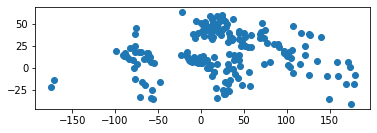

In [3]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities.plot()

In [4]:
cities.sample(5)

,name,geometry
27,Bujumbura,POINT (29.36001 -3.37609)
23,Djibouti,POINT (43.14800 11.59501)
134,Ankara,POINT (32.86245 39.92918)
97,Vientiane,POINT (102.59998 17.96669)
73,Amman,POINT (35.93135 31.95197)


In this toy city dataset, you will notice that we have cities' names, but not the country in which they are located. Since we know this variable is in our `world` dataset, we can do a spatial join to match each city observation up with the country in which it is located:

In [5]:
cities_w_county = cities.sjoin(world, how="left", predicate='intersects')
cities_w_county.sample(3)

,name_left,geometry,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est
189,Cape Town,POINT (18.43304 -33.91807),25.0,54841552.0,Africa,South Africa,ZAF,739100.0
200,Santiago,POINT (-70.66899 -33.44807),10.0,17789267.0,South America,Chile,CHL,436100.0
50,Niamey,POINT (2.11471 13.51865),55.0,19245344.0,Africa,Niger,NER,20150.0


Voilá! Just like that we've merged two datasets that have no variables in common. 

Note that like our regular merge/join methods, we can use `how` to dictate which observations remain in our joined dataset. Unlike a regular merge/join, though, we also have the argument `predicate` which dictates what spatial relationships should be merged. When merging points with polygons, there aren't a lot of ways you can imagine rows relating to one another. But spatial joins can also be done with lines and polygons (say, matching roads with the states they cross), or with polygons and polygons (matching media markets to states), and in those settings you can imagine more complicated relationships. For example, perhaps we only want to join roads to states if the road lies entirely within the state; or perhaps we want to join our roads to any state they touch. To accommodate these different relationships, `predicate` accepts:

- intersects
- contains
- within
- touches
- crosses
- overlaps



### Order of Join

Note that while normal merge/join are symmetric -- it doesn't really matter which is the right dataset and which is left -- order does matter for spatial joins, as only the *geometry* of one dataset is preserved. So if we do `cities.sjoin(world)`, the resulting geodataframe will be points (as above). But if we flip the order, we end up with country polygons:

<AxesSubplot:>

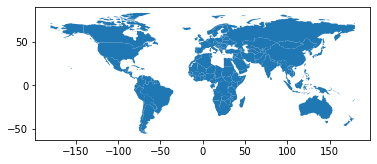

In [6]:
world.sjoin(cities).plot()

## Nearest Spatial Join

`sjoin` is terrific for linking observations that are in the same location. But sometimes we're interested not in joining records that are in exactly the same spot or are overlapping, but rather observations that are *near* to one another. 

For that, geopandas has `sjoin_nearest`. `sjoin_nearest`, as the name implies, merges an observation in one dataset to the *nearest* observation in another dataset. 

To illustrate, let's find out what city is closest to the "middle" of each country (e.g. closest to each country's centroid):

In [7]:
world["centroids"] = world.centroid
world = world.set_geometry("centroids")
center_most_city = world.sjoin_nearest(cities, how="inner")
center_most_city = center_most_city.rename(
    {"name_right": "centermost_city"}, axis="columns"
)
center_most_city.sample(3)


/var/folders/tj/s8f2_ks15h315z5thvtnhz8r0000gp/T/ipykernel_40833/416860634.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["centroids"] = world.centroid
/Users/Nick/opt/miniconda3/lib/python3.9/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,pop_est,continent,name_left,iso_a3,gdp_md_est,geometry,centroids,index_right,centermost_city
171,2103721,Europe,Macedonia,MKD,29520.0,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",POINT (21.69790 41.60593),25,Skopje
157,28036829,Asia,Yemen,YEM,73450.0,"POLYGON ((52.00001 19.00000, 52.78218 17.34974...",POINT (47.53504 15.91323),136,Sanaa
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",POINT (-2.87670 42.46070),166,Madrid


(Note we're getting those same errors about calculating distances using a "geographic CRS" we got before. Once again, geopandas is telling us something important, and I **definitely** wouldn't ignore these warnings in a real analysis. I just want to put off discussion of projections till a [future reading](gis_projections_and_crs.ipynb).)

Voilá! Obviously this isn't the *most* compelling illustrative example, but you could easily see how this might be helpful for, say, finding the supply depots closest to each store, the polling place closest to each voter, etc.

## Geometric Manipulations

As we saw above, geopandas has utilities (like `.centroid`) for manipulating the geometric objects. The [full like of supported manipulations can be found here](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html), but some of the most useful are:

- generating centroids (`.centroid`), 
- calculating geometric properties like area or length (`.area` and `.length`), and 
- dissolving all the distinct geometries in a geodataframe into a single shape (`.unary_union`). 

Perhaps the most useful for relating data, though, is `.buffer()`. Buffer takes a set of points and converts them into circular polygons of a given radius. This is *extremely* useful if you, say, want to do a spatial join to find all the observations in another dataset that are within a given distance of your original points. 

To illustrate, suppose you wanted to find all the cities within 500 kilometers of each city in our `cities` dataset -- how would you do it?

Well, we can start by using `.buffer()` to create a new GeoDataFrame with circular polygons instead of points. Then we can do a spatial join of that new GeoDataFrame with our original cities GeoDataFrame to find all the cities that intersect each city's 500 km circle. 

Note that to do this, I *do* have to play with the projection of our data a little. As we found before, our data is currently represented by x-y coordinates written in terms of degrees of latitude and longitude. But to create a buffer of 500 kilometers, we need to first move to a projection where the units are in meters, which I can do with `.to_crs()`:

<AxesSubplot:>

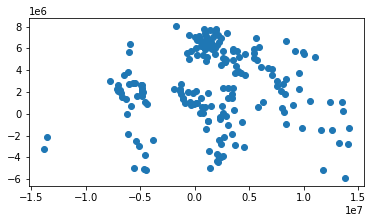

In [8]:
cities_reprojected = cities.to_crs("+proj=cea +lon_0=0 +lat_ts=45 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
cities_reprojected.plot()

And now we can do our buffer and join:

<AxesSubplot:>

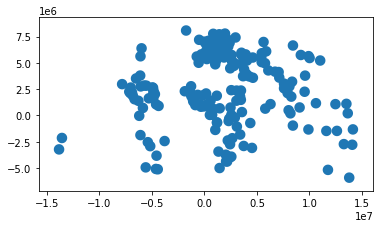

In [9]:
# Create circular polygons with buffer
cities_reprojected["buffers"] = cities_reprojected.buffer(500_000)

# Make the buffers the "official geometry"
city_buffers = cities_reprojected.set_geometry("buffers")
city_buffers.plot()

I know that plot looks very similar to the one above, but that's just an illusion of the plots -- the plot we created before buffering turned our points into circles to help visualize them, but from the perspective of geopandas, they're just points with zero area. Now that we've buffered them, however, they're actually polygons with diameters of 500 kilometers:

In [10]:
city_buffers.sample(3)

,name,geometry,buffers
113,Cotonou,POINT (198539.858 997409.897),"POLYGON ((698539.858 997409.897, 696132.222 94..."
39,Ashgabat,POINT (4603338.357 5510032.486),"POLYGON ((5103338.357 5510032.486, 5100930.721..."
60,Honiara,POINT (12611532.802 -1466922.188),"POLYGON ((13111532.802 -1466922.188, 13109125...."


With areas of $500,000^2 \pi = 7.85 * 10^{11}$ meters squared: 

In [11]:
city_buffers.sample(3).area

149    7.841371e+11
52     7.841371e+11
167    7.841371e+11
dtype: float64

So now we can do a spatial join of these circular polygons with our city points, and any cities that intersect with these buffers will be matched up, giving us a dataset of cities and their neighbors!

In [12]:
# Now join the polygons with our points
joined = cities_reprojected.sjoin(city_buffers[["name", "buffers"]])
joined.sample(5)

,name_left,geometry,buffers,index_right,name_right
4,Palikir,POINT (12469624.946 1077231.960),"POLYGON ((12969624.946 1077231.960, 12967217.3...",4,Palikir
87,Tallinn,POINT (1949727.750 7727330.615),"POLYGON ((2449727.750 7727330.615, 2447320.113...",154,Helsinki
86,Zagreb,POINT (1261548.941 6427274.597),"POLYGON ((1761548.941 6427274.597, 1759141.304...",86,Zagreb
192,Rome,POINT (984111.993 5985209.844),"POLYGON ((1484111.993 5985209.844, 1481704.357...",16,Ljubljana
21,Pristina,POINT (1668870.870 6074546.314),"POLYGON ((2168870.870 6074546.314, 2166463.233...",137,Bucharest


In [13]:
# Cleanup columns
joined = joined.rename(
    {"name_left": "city_name", "name_right": "nearby_city"}, axis="columns"
)
joined = joined.drop(["index_right", "buffers"], axis="columns")

# Cities are obviously within 500 kilometers of themselves, so
# drop the "self joins"
joined = joined[~(joined.city_name == joined.nearby_city)]

# Now check out a few!
joined.sort_values("city_name")


,city_name,geometry,nearby_city
156,Abidjan,POINT (-318698.444 829665.928),Accra
156,Abidjan,POINT (-318698.444 829665.928),Yamoussoukro
156,Abidjan,POINT (-318698.444 829665.928),Lome
38,Abu Dhabi,POINT (4286633.823 3707394.154),Doha
38,Abu Dhabi,POINT (4286633.823 3707394.154),Manama
...,...,...,...
86,Zagreb,POINT (1261548.941 6427274.597),Sarajevo
86,Zagreb,POINT (1261548.941 6427274.597),Podgorica
86,Zagreb,POINT (1261548.941 6427274.597),Budapest
86,Zagreb,POINT (1261548.941 6427274.597),Belgrade


And that's how we can compose operations to do some pretty amazing things!